# Model based on embeddings

The idea is based on embeddings, as explained by Jeremy Howard of [fast.ai].

The code is taken from [3rd place winner](https://github.com/entron/entity-embedding-rossmann) of a similar [competition](https://www.kaggle.com/c/rossmann-store-sales/) on Kaggle.

In [31]:
import pandas as pd
import numpy as np

%matplotlib inline
%config Completer.use_jedi = False


In [32]:
from keras.models import Sequential
from keras.models import Model as KerasModel
from keras.layers import Input, Dense, Activation, Reshape, Dropout, Dot
from keras.layers import Concatenate
from keras.layers.embeddings import Embedding
from keras.callbacks import ModelCheckpoint
from keras import optimizers


In [33]:
ds = pd.read_feather('../data/train_for_test.ftr')

In [34]:
ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3646331 entries, 0 to 3646330
Data columns (total 10 columns):
date_block_num           category
shop_id                  category
item_id                  category
item_cnt_month           float64
item_price               float64
year                     category
month                    category
item_cnt_month_lag_1     float64
item_cnt_month_lag_2     float64
item_cnt_month_lag_12    float64
dtypes: category(5), float64(5)
memory usage: 160.8 MB


In [35]:
ds.drop(columns=['item_price','item_cnt_month_lag_1', 'item_cnt_month_lag_2',
       'item_cnt_month_lag_12'],inplace=True)

In [36]:
ds.head()

,date_block_num,shop_id,item_id,item_cnt_month,year,month
0,0,2,30,0.0,2013,1
1,0,42,4352,0.0,2013,1
2,0,42,4354,0.0,2013,1
3,0,42,4356,0.0,2013,1
4,0,42,4357,0.0,2013,1


In [37]:
embedding_columns=['shop_id','item_id']
for c in embedding_columns:
    ds[c].cat.remove_unused_categories(inplace=True)

In [38]:
n_levels = ds[embedding_columns].nunique()
n_levels

shop_id      42
item_id    4716
dtype: int64

In [39]:
ds[embedding_columns].max()

shop_id       59.0
item_id    22167.0
dtype: float64

In [70]:
n_dimensions=n_levels.copy()
n_dimensions.iloc[range(2)]=[4,4]
n_dimensions

shop_id    4
item_id    4
dtype: int64

In [71]:
input_shop = Input(shape=(1,))
output_shop = Embedding(n_levels.shop_id, n_dimensions.shop_id, name='shop_embedding')(input_shop)
output_shop = Reshape(target_shape=(n_dimensions.shop_id,))(output_shop)


In [72]:
input_item = Input(shape=(1,))
output_item = Embedding(n_levels.item_id, n_dimensions.item_id, name='item_embedding')(input_item)
output_item = Reshape(target_shape=(n_dimensions.item_id,))(output_item)


In [73]:

input_model = [input_shop ,input_item]
output_embeddings = [output_shop,output_item]



In [74]:
output_model = Dot(axes=(1,1), normalize=False)([output_shop,output_item])

model = KerasModel(inputs=[input_shop,input_item], outputs=output_model)

In [75]:
dsmall=ds.groupby(['shop_id','item_id'], as_index=False)['item_cnt_month'].mean().dropna()

x=[dsmall[c].cat.codes.values for c in ['shop_id','item_id']]
y=dsmall.item_cnt_month.clip(lower=0,upper=40)
x,len(x[0])

([array([ 0,  0,  0, ..., 41, 41, 41], dtype=int8),
  array([   0,    1,    2, ..., 4711, 4713, 4715], dtype=int16)],
 111404)

In [89]:
sgd = optimizers.SGD(lr=0.4, decay=1e-6, momentum=0.5, nesterov=True)
model.compile(loss='mean_squared_error', optimizer=sgd)

In [92]:
model.fit(x,y,validation_split=0,epochs=30,verbose=1,batch_size=2048)

Epoch 1/30
111404/111404 [==============================] - 0s 2us/step - loss: 0.0962
Epoch 2/30
111404/111404 [==============================] - 0s 2us/step - loss: 0.0962
Epoch 3/30
111404/111404 [==============================] - 0s 2us/step - loss: 0.0962
Epoch 4/30
111404/111404 [==============================] - 0s 2us/step - loss: 0.0961
Epoch 5/30
111404/111404 [==============================] - 0s 2us/step - loss: 0.0961
Epoch 6/30
111404/111404 [==============================] - 0s 2us/step - loss: 0.0961
Epoch 7/30
111404/111404 [==============================] - 0s 2us/step - loss: 0.0961
Epoch 8/30
111404/111404 [==============================] - 0s 2us/step - loss: 0.0961
Epoch 9/30
111404/111404 [==============================] - 0s 2us/step - loss: 0.0961
Epoch 10/30
111404/111404 [==============================] - 0s 2us/step - loss: 0.0962
Epoch 11/30
111404/111404 [==============================] - 0s 2us/step - loss: 0.0961
Epoch 12/30
111404/111404 [==============

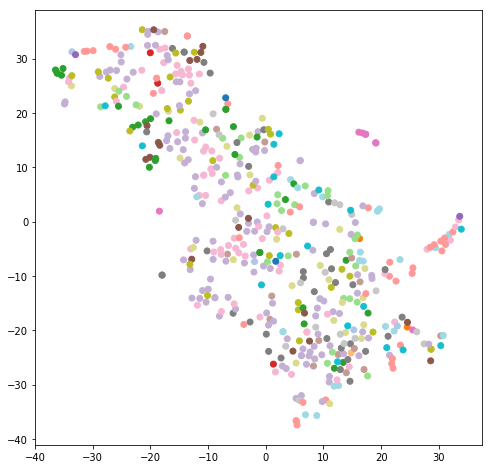

In [93]:
from sklearn import manifold
import matplotlib.pyplot as plt
%matplotlib inline

items=pd.read_csv('../readonly/final_project_data/items.csv',index_col='item_id')

full_embeddings=model.get_layer('item_embedding').get_weights()[0]
n_full = len(full_embeddings)
n_plot=500
pick_idx=np.random.choice(range(n_full),size=n_plot)
plot_embeddings=full_embeddings[pick_idx]
item_cats=items.iloc[dsmall.item_id.cat.categories[pick_idx]].item_category_id.values

tsne = manifold.TSNE(init='pca', random_state=0, method='exact')
Y = tsne.fit_transform(plot_embeddings)
plt.figure(figsize=(8,8))
plt.scatter(-Y[:, 0], -Y[:, 1],c=item_cats,cmap='tab20')
#for i, txt in enumerate(ds.item_id.cat.categories[pick_idx]):
#    plt.annotate(txt, (-Y[i, 0],-Y[i, 1]), xytext = (-1, 1), textcoords = 'offset points')



In [100]:
test=pd.read_csv('../readonly/final_project_data/test.csv')

In [111]:
test.shop_id=pd.Categorical(test.shop_id,categories=dsmall.shop_id.cat.categories)
test.item_id=pd.Categorical(test.item_id,categories=dsmall.item_id.cat.categories)
new_items_idx=test.item_id.isna()
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214200 entries, 0 to 214199
Data columns (total 3 columns):
ID         214200 non-null int64
shop_id    214200 non-null category
item_id    198072 non-null category
dtypes: category(2), int64(1)
memory usage: 2.4 MB


In [112]:
x_test=[test.loc[~new_items_idx,c].cat.codes.values for c in ['shop_id','item_id']]
x_test,len(x_test[0])



([array([ 3,  3,  3, ..., 29, 29, 29], dtype=int8),
  array([1105, 1147, 1146, ..., 3435, 4244,  144], dtype=int16)],
 198072)

In [124]:
test.loc[~new_items_idx,'item_cnt_month']=model.predict(x_test)

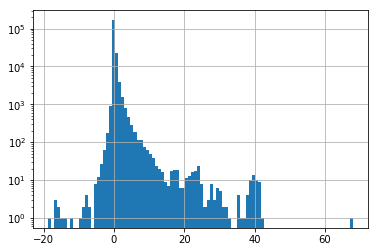

In [125]:
test.item_cnt_month.hist(bins=100,log=True)

In [129]:
test.item_cnt_month.fillna(value=0.0,inplace=True)

In [130]:
test.item_cnt_month.clip(lower=0,upper=20,inplace=True)

In [131]:
test.to_csv('../data/submit_shop_item_embed_fill0.csv',header=True,index=False,columns=['ID','item_cnt_month'])